# Collaboration and Competition

---

In this notebook, you will learn how to use the Unity ML-Agents environment for the third project of the [Deep Reinforcement Learning Nanodegree](https://www.udacity.com/course/deep-reinforcement-learning-nanodegree--nd893) program.

### 1. Start the Environment

We begin by importing the necessary packages.  If the code cell below returns an error, please revisit the project instructions to double-check that you have installed [Unity ML-Agents](https://github.com/Unity-Technologies/ml-agents/blob/master/docs/Installation.md) and [NumPy](http://www.numpy.org/).

In [1]:
from unityagents import UnityEnvironment
import numpy as np
import matplotlib.pyplot as plt 
%matplotlib inline 

In [2]:
env = UnityEnvironment(file_name="./Tennis_Windows_x86_64/Tennis.exe")

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [3]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

In this environment, two agents control rackets to bounce a ball over a net. If an agent hits the ball over the net, it receives a reward of +0.1.  If an agent lets a ball hit the ground or hits the ball out of bounds, it receives a reward of -0.01.  Thus, the goal of each agent is to keep the ball in play.

The observation space consists of 8 variables corresponding to the position and velocity of the ball and racket. Two continuous actions are available, corresponding to movement toward (or away from) the net, and jumping. 

Run the code cell below to print some information about the environment.

In [4]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents 
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 2
Size of each action: 2
There are 2 agents. Each observes a state with length: 24
The state for the first agent looks like: [ 0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.         -6.65278625 -1.5
 -0.          0.          6.83172083  6.         -0.          0.        ]


### 4. It's Your Turn!

Now it's your turn to train your own agent to solve the environment!  When training the environment, set `train_mode=True`, so that the line for resetting the environment looks like the following:
```python
env_info = env.reset(train_mode=True)[brain_name]
```

In [5]:
from collections import deque, namedtuple
import torch
import random

BATCH_SIZE = 128
BUFFER_SIZE = int(1e6)
UPDATE_EVERY = 4
SEED = 0

In [6]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
class ReplayBuffer:
    """ Fixed-size buffer to store experience tuples."""

    def __init__(self, batch_size, buffer_size, seed):
        self.batch_size = batch_size
        self.memory = deque(maxlen=buffer_size)
        self.experience = namedtuple('Experience', field_names=['state', 'action', 'reward', 'next_state', 'done'])
        self.seed = random.seed(seed)

    def add(self, state, action, reward, next_state, done):
        e = self.experience(state=state, action=action, reward=reward, next_state=next_state, done=done)
        self.memory.append(e)

    def sample(self):
        experiences = random.sample(self.memory, k=self.batch_size)
        states = torch.from_numpy(np.vstack([np.reshape(e.state, (1, -1)) for e in experiences if e is not None])).float().to(device)
        actions = torch.from_numpy(np.vstack([np.reshape(e.action, (1, -1)) for e in experiences if e is not None])).float().to(device)
        rewards = torch.from_numpy(np.vstack([e.reward for e in experiences if e is not None])).float().to(device)
        next_states = torch.from_numpy(np.vstack([np.reshape(e.next_state, (1, -1)) for e in experiences if e is not None])).float().to(
            device)
        dones = torch.from_numpy(np.vstack([e.done for e in experiences if e is not None]).astype(np.uint8)).float().to(device)
        return (states, actions, rewards, next_states, dones)

    def __len__(self):
        return len(self.memory)


### Solution 1: MADDPG algorithm from the paper 

Here the task is solved using the algorithm mentioned in the MADDPG paper by Lowe et al. This algorithm in the paper covers the general case where the agents involved in the task could be fully co-operative, or fully competitive or mixed co-operative competitive in the environment. 

In [7]:
from maddpg_agent import Agent
def maddpg(num_episodes=12000, print_every=100):
    replay_memory = ReplayBuffer(BATCH_SIZE, BUFFER_SIZE, SEED)
    display_flag = 1
    scores_deque = deque(maxlen=100)
    scores = []
    agents = []
    for agent_id in range(num_agents):
        agents.append(Agent(agent_id, num_agents, state_size, action_size))
    # Now on, let us assume the first component of states, rewards, done from the environment correspond to agent 0.
    for i_episode in range(num_episodes):
        env_info = env.reset(train_mode=True)[brain_name]
        states = env_info.vector_observations
        for agent_id in range(num_agents):
            agents[agent_id].reset()
        score = np.zeros(num_agents)
        t = 0
        while True:
            actions = []
            with torch.no_grad():
                for agent_id in range(num_agents):
                    actions.append(agents[agent_id].act(states[agent_id, :]))
                actions = np.squeeze(np.array(actions), axis=1)
            env_info = env.step(actions)[brain_name]
            next_states = env_info.vector_observations
            rewards = env_info.rewards
            dones = env_info.local_done
            replay_memory.add(states, actions, rewards, next_states, dones)
            t = t + 1
            temp_t = t % UPDATE_EVERY
            if temp_t == 0:
                if len(replay_memory) > BATCH_SIZE:
                    for agent_id in range(num_agents):
                        experiences = replay_memory.sample()
                        other_agents = agents.copy()
                        other_agents.remove(agents[agent_id])
                        agents[agent_id].learn(experiences, other_agents)

            score += env_info.rewards
            states = next_states
            if np.any(dones):
                break
        scores.append(score)
        scores_deque.append(np.max(score))

        print('\rEpisode {} \t Score: {:.3f}, {:.3f}'.format(i_episode, score[0], score[1]), end='')
        if i_episode % print_every == 0:
            print('\r Episode {} \t Average Score: {:.3f}'.format(i_episode, np.mean(scores_deque)))
        if np.mean(scores_deque) >= 0.5 and display_flag:
            print('\r Episode {} \t Average Score: {:.3f}'.format(i_episode, np.mean(scores_deque)))
            print('\r \t ****Task learned in {} episodes****'.format(i_episode))
            display_flag = 0
            break
    for i in range(num_agents):
        torch.save(agents[i].actor_local.state_dict(), 'checkpoint_actor_' + str(i) + '.pth')
        torch.save(agents[i].critic_local.state_dict(), 'checkpoint_critic_' + str(i) + '.pth')

    return scores

scores = maddpg()

c:\users\bsankaranarayanan2\pycharmprojects\udacity_drl_nd\venv\lib\site-packages\torch\nn\functional.py:1628: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 Episode 0 	 Average Score: 0.000
 Episode 100 	 Average Score: 0.008
 Episode 200 	 Average Score: 0.005
 Episode 300 	 Average Score: 0.001
 Episode 400 	 Average Score: 0.000
 Episode 500 	 Average Score: 0.000
 Episode 600 	 Average Score: 0.000
 Episode 700 	 Average Score: 0.000
 Episode 800 	 Average Score: 0.000
 Episode 900 	 Average Score: 0.000
 Episode 1000 	 Average Score: 0.001
 Episode 1100 	 Average Score: 0.000
 Episode 1200 	 Average Score: 0.040
 Episode 1300 	 Average Score: 0.027
 Episode 1400 	 Average Score: 0.017
 Episode 1500 	 Average Score: 0.040
 Episode 1600 	 Average Score: 0.022
 Episode 1700 	 Average Score: 0.017
 Episode 1800 	 Average Score: 0.018
 Episode 1900 	 Average Score: 0.018
 Episode 2000 	 Average Score: 0.029
 Episode 2100 	 Average Score: 0.029
 Episode 2200 	 Average Score: 0.053
 Episode 2300 	 Average Score: 0.044
 Episode 2400 	 Average Score: 0.048
 Episode 2500 	 Average Score: 0.055
 Episode 2600 	 Average Score: 0.093
 Episode 2700

In [8]:
scores = np.array(scores)
max_scores = np.max(scores, 1)

Text(0, 0.5, 'Reward per episode')

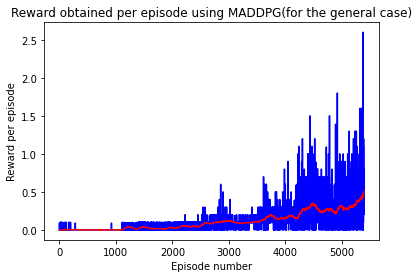

In [9]:
running_window_length = 100
running_avg = np.zeros((len(max_scores), ))
for i in range(running_window_length, len(max_scores)):
    running_avg[i] = np.mean(max_scores[i-100:i])
plt.plot(max_scores, 'b')
plt.plot(running_avg, 'r')
plt.title('Reward obtained per episode using MADDPG(for the general case)')
plt.xlabel('Episode number')
plt.ylabel('Reward per episode')

### Solution 2 - MADDPG algorithm, same as in the paper, except using a common critic for both the agents

#### The solution learns the task but not working as an intended improvement to MADDPG. 

For the Tennis playing task described in the problem statement, it is observed that the two agents are required to be fully co-operative to achieve the maximum reward and learn the task. This is a specific case of two fully **co-operative agents** playing in the Tennis environment, with the common goal of trying to keep the ball in the game for as long as possible. Hence, it is worth a try to use a common critic in the general MADDPG algorithm in order to try and improve the learning speed.

The aim was to get the agents to learn faster than the vanilla DDPG using this solution implemented below. However, due to issues with hyper-parameter tuning, a big improvement is not seen. Nevertheless, it was worth a try.

In [7]:
from maddpg_common_critic import Agent
def maddpg_common_critic(num_episodes=5000, print_every=100):
    replay_memory = ReplayBuffer(BATCH_SIZE, BUFFER_SIZE, SEED)
    display_flag = 1
    scores_deque = deque(maxlen=100)
    scores = []
    agents = []
    for agent_id in range(num_agents):
        agents.append(Agent(agent_id, num_agents, state_size, action_size))
        
    # assume the first component of states, rewards, done from the environment correspond to agent 0.
    for i_episode in range(num_episodes):
        env_info = env.reset(train_mode=True)[brain_name]
        states = env_info.vector_observations
        for agent_id in range(num_agents):
            agents[agent_id].reset()
        score = np.zeros(num_agents)
        t = 0
        while True:
            actions = []
            with torch.no_grad():
                for agent_id in range(num_agents):
                    actions.append(agents[agent_id].act(states[agent_id, :]))
                actions = np.squeeze(np.array(actions), axis=1)
            env_info = env.step(actions)[brain_name]
            next_states = env_info.vector_observations
            rewards = env_info.rewards
            dones = env_info.local_done
            replay_memory.add(states, actions, rewards, next_states, dones)
            t = t + 1
            temp_t = t % UPDATE_EVERY
            if temp_t == 0:
                if len(replay_memory) > BATCH_SIZE:
                    for agent_id in range(num_agents):
                        experiences = replay_memory.sample()
                        other_agents = agents.copy()
                        other_agents.remove(agents[agent_id])
                        agents[agent_id].learn(experiences, other_agents)

            score += env_info.rewards
            states = next_states
            if np.any(dones):
                break
        scores.append(score)
        scores_deque.append(np.max(score))

        print('\rEpisode {} \t Score: {:.3f}, {:.3f}'.format(i_episode, score[0], score[1]), end='')
        if i_episode % print_every == 0:
            print('\r Episode {} \t Average Score: {:.3f}'.format(i_episode, np.mean(scores_deque)))
        if np.mean(scores_deque) >= 0.5 and display_flag:
            print('\r Episode {} \t Average Score: {:.3f}'.format(i_episode, np.mean(scores_deque)))
            print('\r \t ****Task learned in {} episodes****'.format(i_episode))
            display_flag = 0
            break
    for i in range(num_agents):
        torch.save(agents[i].actor_local.state_dict(), 'checkpoint_actor_' + str(i) + '.pth')
        torch.save(agents[i].critic_local.state_dict(), 'checkpoint_critic_' + str(i) + '.pth')

    return scores

scores = maddpg_common_critic()

c:\users\bsankaranarayanan2\pycharmprojects\udacity_drl_nd\venv\lib\site-packages\torch\nn\functional.py:1628: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 Episode 0 	 Average Score: 0.000
 Episode 100 	 Average Score: 0.017
 Episode 200 	 Average Score: 0.001
 Episode 300 	 Average Score: 0.007
 Episode 400 	 Average Score: 0.035
 Episode 500 	 Average Score: 0.037
 Episode 600 	 Average Score: 0.047
 Episode 700 	 Average Score: 0.046
 Episode 800 	 Average Score: 0.047
 Episode 900 	 Average Score: 0.049
 Episode 1000 	 Average Score: 0.056
 Episode 1100 	 Average Score: 0.036
 Episode 1200 	 Average Score: 0.036
 Episode 1300 	 Average Score: 0.057
 Episode 1400 	 Average Score: 0.050
 Episode 1500 	 Average Score: 0.057
 Episode 1600 	 Average Score: 0.088
 Episode 1700 	 Average Score: 0.083
 Episode 1800 	 Average Score: 0.083
 Episode 1900 	 Average Score: 0.094
 Episode 2000 	 Average Score: 0.089
 Episode 2100 	 Average Score: 0.100
 Episode 2200 	 Average Score: 0.101
 Episode 2300 	 Average Score: 0.075
 Episode 2400 	 Average Score: 0.094
 Episode 2500 	 Average Score: 0.098
 Episode 2600 	 Average Score: 0.107
 Episode 2700

Text(0, 0.5, 'Reward per episode')

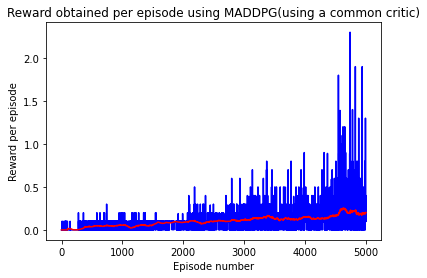

In [8]:
scores = np.array(scores)
max_scores = np.max(scores, 1)
running_window_length = 100
running_avg = np.zeros((len(max_scores), ))
for i in range(running_window_length, len(max_scores)):
    running_avg[i] = np.mean(max_scores[i-100:i])
plt.plot(max_scores, 'b')
plt.plot(running_avg, 'r')
plt.title('Reward obtained per episode using MADDPG(using a common critic)')
plt.xlabel('Episode number')
plt.ylabel('Reward per episode')